In [1]:
import string
import random
from timeit import default_timer as timer
from time import sleep, process_time
from matplotlib import pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture
import pandas as pd
import scipy

In [2]:
alphabet = string.ascii_uppercase + string.ascii_lowercase + string.digits
print(f"Alphabet: {alphabet}")

Alphabet: ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789


In [3]:
unknown_password = ''.join(random.choices(alphabet, k=24))
print(f"Unknown password: {unknown_password}")

Unknown password: qh9jWHQIPhFvtf5pkWes2Tza


In [4]:
def password_compare(unknown_password, guess_password):
    
    i = 0
    
    while i < len(unknown_password) and i < len(guess_password):
       
        if unknown_password[i] != guess_password[i]:
            return
                
        i += 1

In [5]:
def password_query(guess_password):
    
    start = process_time()
    password_compare(unknown_password, guess_password)
    end = process_time()

    return (end - start)

In [75]:
n_queries = 500
deltas = []

for character in alphabet:
    
    for _ in range(n_queries):

        # Note: '!' is NOT in the alphabet! This is important!
        guess_password_km1 = unknown_password[:12] + ('!' * 12)
        t_km1 = password_query(guess_password_km1)

        guess_password_k = unknown_password[:12] + character + ('!' * 11)        
        t_k = password_query(guess_password_k)

        deltas += [(t_k - t_km1)]

In [76]:
delta_range = np.median(deltas) - 1.5 * (np.quantile(deltas, 0.95) - np.quantile(deltas, 0.05)), \
              np.median(deltas) + 1.5 * (np.quantile(deltas, 0.95) - np.quantile(deltas, 0.05))
print(f"Range: {delta_range}")

Range: (-9.851500030855208e-07, 9.651500085361407e-07)


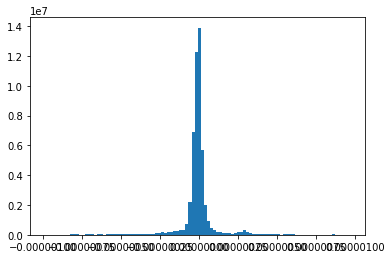

In [77]:
_ = plt.hist(deltas, range=delta_range, density=True, bins=100)

In [78]:
next_char_index = alphabet.find(unknown_password[12])
print(f"Next character index: {next_char_index}")

Next character index: 45


In [79]:
incorrect_deltas = deltas[:next_char_index * n_queries] + deltas[(next_char_index + 1) * n_queries:]
correct_deltas = deltas[next_char_index * n_queries:(next_char_index + 1) * n_queries]

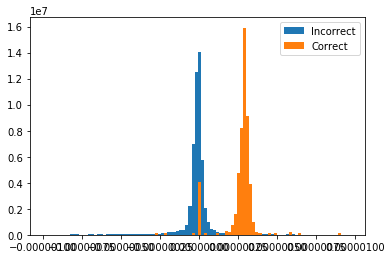

In [80]:
_ = plt.hist(incorrect_deltas, range=delta_range, density=True, bins=100, label='Incorrect')
_ = plt.hist(correct_deltas, range=delta_range, density=True, bins=100, label='Correct')
_ = plt.legend()

In [81]:
clean_deltas = list(filter(lambda delta: delta > delta_range[0] and delta < delta_range[1], deltas))

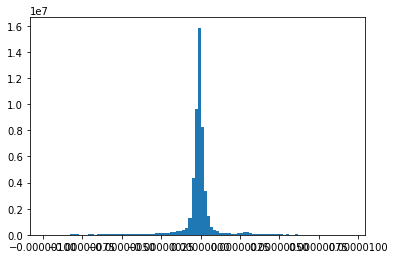

In [82]:
_ = plt.hist(clean_deltas, density=True, bins=100)

In [83]:
clean_std = np.std(clean_deltas)
print(f"Clean delta standard deviation: {clean_std}")

Clean delta standard deviation: 1.3016905283353586e-07


In [84]:
std_clean_deltas = np.array(clean_deltas) / clean_std

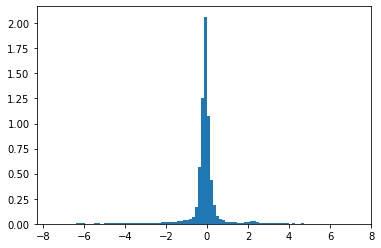

In [85]:
_ = plt.hist(std_clean_deltas, density=True, bins=100)

In [86]:
clean_delta_range = delta_range[0] / clean_std, delta_range[1] / clean_std

In [87]:
medians = []

for i in range(len(alphabet)):
    
    medians += [np.median(deltas[i * n_queries : (i + 1) * n_queries])]

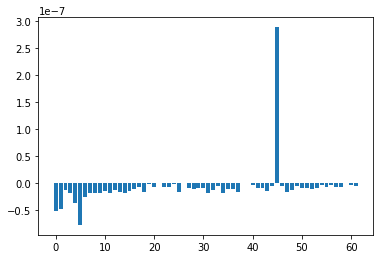

In [88]:
_ = plt.bar(range(len(alphabet)), medians)

In [89]:
print(f"Next character guess: {np.argmax(medians)}")

Next character guess: 45


In [90]:
gmm = GaussianMixture(n_components=2)
_ = gmm.fit(np.array(std_clean_deltas).reshape(-1, 1))

In [91]:
print(f"Means: {gmm.means_[0, 0]}, {gmm.means_[1, 0]}")
print(f"Variances: {gmm.covariances_[0, 0, 0]}, {gmm.covariances_[1, 0, 0]}")
print(f"Weights: {gmm.weights_[0]}, {gmm.weights_[1]}")

Means: -0.22338783863300654, -0.07888997636362845
Variances: 6.018025677637183, 0.03769430800863821
Weights: 0.16044164506105363, 0.8395583549389252


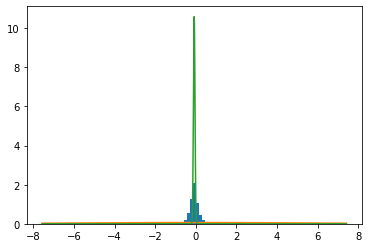

In [92]:
_ = plt.hist(std_clean_deltas, bins=100, density=True)

xx = np.arange(clean_delta_range[0], clean_delta_range[1], 0.01)

_ = plt.plot(xx, scipy.stats.norm.pdf(xx, gmm.means_[0,0], gmm.covariances_[0,0,0]))
_ = plt.plot(xx, scipy.stats.norm.pdf(xx, gmm.means_[1,0], gmm.covariances_[1,0,0]))

In [93]:
correct_distribution = np.argmin(gmm.weights_)
print(f"Correct distribution: {correct_distribution}")

Correct distribution: 0


In [94]:
probs = []

for i in range(len(alphabet)):
    
    if correct_distribution == 1:
        probs += [np.sum(gmm.predict(np.array(deltas[i * n_queries : (i + 1) * n_queries]).reshape(-1, 1) / clean_std)) / n_queries]
    else:
        probs += [np.sum(1 - gmm.predict(np.array(deltas[i * n_queries : (i + 1) * n_queries]).reshape(-1, 1) / clean_std)) / n_queries]

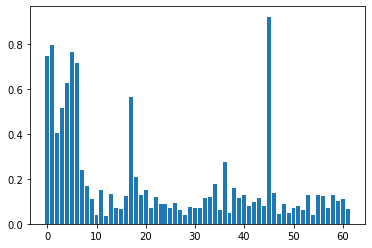

In [95]:
_ = plt.bar(range(0, len(alphabet)), probs)

In [96]:
print(f"Next character guess: {np.argmax(probs)}")

Next character guess: 45


In [97]:
def password_compare(unknown_password, guess_password):
    
    return (unknown_password == guess_password)

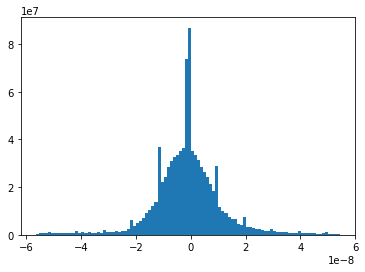

In [98]:
n_queries = 1000
deltas = []

for character in alphabet:
    
    for _ in range(n_queries):

        # Note: '!' is NOT in the alphabet! This is important!
        guess_password_km1 = unknown_password[:12] + ('!' * 12)
        t_km1 = password_query(guess_password_km1)

        guess_password_k = unknown_password[:12] + character + ('!' * 11)        
        t_k = password_query(guess_password_k)

        deltas += [(t_k - t_km1)]

delta_range = np.median(deltas) - 1.5 * (np.quantile(deltas, 0.9) - np.quantile(deltas, 0.1)), \
              np.median(deltas) + 1.5 * (np.quantile(deltas, 0.9) - np.quantile(deltas, 0.1))

_ = plt.hist(deltas, range=delta_range, density=True, bins=100)

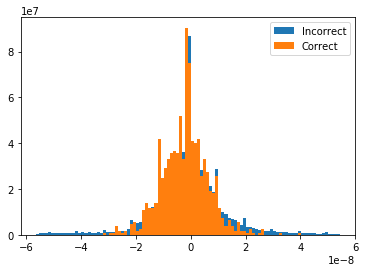

In [99]:
incorrect_deltas = deltas[:next_char_index * n_queries] + deltas[(next_char_index + 1) * n_queries:]
correct_deltas = deltas[next_char_index * n_queries:(next_char_index + 1) * n_queries]

_ = plt.hist(incorrect_deltas, range=delta_range, density=True, bins=100, label='Incorrect')
_ = plt.hist(correct_deltas, range=delta_range, density=True, bins=100, label='Correct')
_ = plt.legend()

In [100]:
clean_deltas = list(filter(lambda delta: delta > delta_range[0] and delta < delta_range[1], deltas))

In [101]:
clean_std = np.std(clean_deltas)
print(f"Clean delta standard deviation: {clean_std}")

Clean delta standard deviation: 1.2661343567330932e-08


In [102]:
std_clean_deltas = np.array(clean_deltas) / clean_std

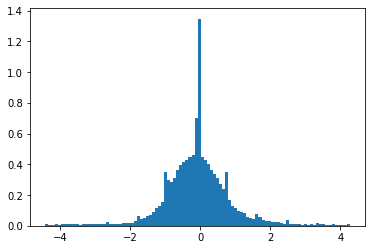

In [103]:
_ = plt.hist(std_clean_deltas, density=True, bins=100)

In [104]:
gmm = GaussianMixture(n_components=2)
_ = gmm.fit(np.array(std_clean_deltas).reshape(-1, 1))

In [105]:
print(f"Means: {gmm.means_[0, 0]}, {gmm.means_[1, 0]}")
print(f"Variances: {gmm.covariances_[0, 0, 0]}, {gmm.covariances_[1, 0, 0]}")
print(f"Weights: {gmm.weights_[0]}, {gmm.weights_[1]}")

Means: 0.029636567094054263, -0.11441827977037523
Variances: 3.4608328136057382, 0.35532234706387816
Weights: 0.20649692032365674, 0.7935030796762761


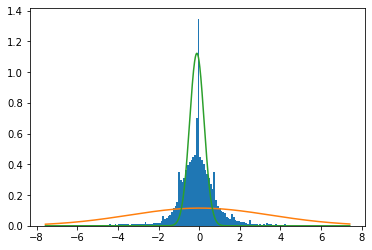

In [106]:
_ = plt.hist(std_clean_deltas, bins=100, density=True)

xx = np.arange(clean_delta_range[0], clean_delta_range[1], 0.01)

_ = plt.plot(xx, scipy.stats.norm.pdf(xx, gmm.means_[0,0], gmm.covariances_[0,0,0]))
_ = plt.plot(xx, scipy.stats.norm.pdf(xx, gmm.means_[1,0], gmm.covariances_[1,0,0]))

In [107]:
correct_distribution = np.argmin(gmm.weights_)
print(f"Correct distribution: {correct_distribution}")

Correct distribution: 0


In [108]:
probs = []

for i in range(len(alphabet)):
    
    if correct_distribution == 1:
        probs += [np.sum(gmm.predict(np.array(deltas[i * n_queries : (i + 1) * n_queries]).reshape(-1, 1) / clean_std)) / n_queries]
    else:
        probs += [np.sum(1 - gmm.predict(np.array(deltas[i * n_queries : (i + 1) * n_queries]).reshape(-1, 1) / clean_std)) / n_queries]

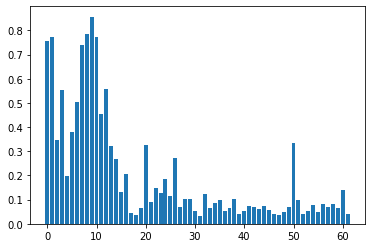

In [109]:
_ = plt.bar(range(0, len(alphabet)), probs)

In [110]:
print(f"Next character guess: {np.argmax(probs)}")

Next character guess: 9
